In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm

sys.path.append('..')
from attention.utils.analysis import task_set_summary

In [2]:
def fit_linear_model(x, y, label, print_stats=False):
    x = sm.add_constant(np.array(x).reshape(-1, 1))
    y = np.array(y).reshape(-1, 1)
    model = sm.OLS(y, x).fit() 
    if print_stats:
        print(
            f'{label}:',
            f'beta0={round(model.params[0], 2)}',
            f'p_beta0={round(model.pvalues[0], 5)}',
            f'beta1={round(model.params[1], 2)}',
            f'p_beta1={round(model.pvalues[1], 5)}',
            f'R2={round(model.rsquared, 2)}')
    return model

def plot_results_predictions(ax, x, ytrue, model, label):
    xminmax = np.array([min(x), max(x)])
    ypred = model.predict(sm.add_constant(xminmax.reshape(-1, 1)))
    if label == 'in':
        ax.plot(x, ytrue, '+k')
        ax.plot(xminmax, ypred, '--r', label='in-set')
    else:
        ax.plot(x, ytrue, 'xk')
        ax.plot(xminmax, ypred, ':b', label='out-of-set')
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    return ax

def add_labels(ax, label1, label2):
    style_bbox = dict(
        boxstyle='circle',
        facecolor='none',
        edgecolor='black')
    xmin, xmax = ax.get_xlim()
    ax.text(
        x=xmin+(0.92*(xmax-xmin)),
        y=0.82*ax.get_ylim()[1],
        s=label1,
        bbox=style_bbox)
    ax.text(
        x=xmin+(0.92*(xmax-xmin)),
        y=0.85*ax.get_ylim()[0],
        s=label2,
        bbox=style_bbox)
    return ax

In [3]:
df_diff = task_set_summary(type_task_set='diff', version_wnids=2, version_weights=3)
x_diff = df_diff['difficulty']
y_diff_in = df_diff['acc_change_in']
y_diff_out = df_diff['acc_change_out']
model_diff_in = fit_linear_model(x_diff, y_diff_in, 'diff_in')
model_diff_out = fit_linear_model(x_diff, y_diff_out, 'diff_out')

df_size = pd.concat((
    task_set_summary(type_task_set='size', version_wnids=4, version_weights=6).iloc[1:],
    task_set_summary(type_task_set='size', version_wnids=5, version_weights=7).iloc[1:]))
x_size = np.log2(df_size['size'])
y_size_in = df_size['acc_change_in']
y_size_out = df_size['acc_change_out']
model_size_in = fit_linear_model(x_size, y_size_in, 'size_in')
model_size_out = fit_linear_model(x_size, y_size_out, 'size_out')

df_sim = pd.concat((
    task_set_summary(type_task_set='sim', version_wnids=3, version_weights=3),
    task_set_summary(type_task_set='sim', version_wnids=4, version_weights=4)))
x_sim = df_sim['similarity']
y_sim_in = df_sim['acc_change_in']
y_sim_out = df_sim['acc_change_out']
model_sim_in = fit_linear_model(x_sim, y_sim_in, 'sim_in')
model_sim_out = fit_linear_model(x_sim, y_sim_out, 'sim_out')

len(x_diff), len(x_size), len(x_sim)

(25, 20, 40)

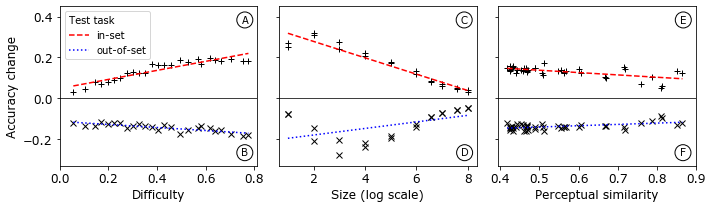

In [4]:
plt.rc('font', size=10) # default
plt.rc('axes', labelsize=12) # axes labels
plt.rc('xtick', labelsize=12) # x tick labels
plt.rc('ytick', labelsize=12) # y tick labels
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif']=['Verdana']

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(10, 3))

ax[0] = plot_results_predictions(ax[0], x_diff, y_diff_in, model_diff_in, 'in')
ax[0] = plot_results_predictions(ax[0], x_diff, y_diff_out, model_diff_out, 'out')
ax[0].set_xlabel('Difficulty')
ax[0].set_xticks(list(np.arange(0, 1, 0.2)))
ax[0].set_ylabel('Accuracy change')
ax[0].set_ylim((-0.33, 0.45))
ax[0] = add_labels(ax[0], 'A', 'B')
leg = ax[0].legend(title='Test task', loc='upper left')
leg._legend_box.align = 'left'

ax[1] = plot_results_predictions(ax[1], x_size, y_size_in, model_size_in, 'in')
ax[1] = plot_results_predictions(ax[1], x_size, y_size_out, model_size_out, 'out')
ax[1].set_xlabel('Size (log scale)')
ax[1] = add_labels(ax[1], 'C', 'D')

ax[2] = plot_results_predictions(ax[2], x_sim, y_sim_in, model_sim_in, 'in')
ax[2] = plot_results_predictions(ax[2], x_sim, y_sim_out, model_sim_out, 'out')
ax[2].set_xlabel('Perceptual similarity')
ax[2].set_xticks(np.arange(0.4, 1, 0.1))
ax[2] = add_labels(ax[2], 'E', 'F')

plt.tight_layout()
plt.savefig('accuracy_change_plots.pdf')
plt.savefig('accuracy_change_plots.png', dpi=300)

In [5]:
x_y_label = [
    [x_diff, y_diff_in, 'difficulty_in'],
    [x_diff, y_diff_out, 'difficulty_out'],
    [x_size, y_size_in, 'size_in'],
    [x_size, y_size_out, 'size_out'],
    [x_sim, y_sim_in, 'similarity_in'],
    [x_sim, y_sim_out, 'similarity_out']]

stats = []
for x, y, label in x_y_label:
    model = fit_linear_model(x, y, label, False)
    spearman = scipy.stats.spearmanr(x, y)
    kendall = scipy.stats.kendalltau(x, y)
    property_, test_task = label.split('_')
    stats.append([
        property_, test_task, spearman.correlation, spearman.pvalue, kendall.correlation, kendall.pvalue,
        model.params[0], model.pvalues[0], model.params[1], model.pvalues[1], model.rsquared])

names = (
    'property', 'test_task', 'rho', 'p_rho', 'tau', 'p_tau', 'beta0', 'p_beta0', 'beta1', 'p_beta1', 'R2')

precision = {}
for name in names[2:]:
    if 'p_' in name:
        precision[name] = 5
    else:
        precision[name] = 2

df = pd.DataFrame(data=stats, columns=names)
df.round(precision)

,property,test_task,rho,p_rho,tau,p_tau,beta0,p_beta0,beta1,p_beta1,R2
0,difficulty,in,0.93,0.00000,0.79,0.00000,0.05,0.00002,0.22,0.00000,0.85
1,difficulty,out,-0.83,0.00000,-0.65,0.00000,-0.11,0.00000,-0.07,0.00000,0.68
2,size,in,-0.97,0.00000,-0.91,0.00000,0.36,0.00000,-0.04,0.00000,0.93
3,size,out,0.69,0.00085,0.59,0.00033,-0.21,0.00001,0.02,0.01812,0.27
4,similarity,in,-0.53,0.00043,-0.38,0.00056,0.19,0.00000,-0.11,0.00002,0.39
5,similarity,out,0.37,0.01998,0.27,0.01538,-0.17,0.00000,0.06,0.00021,0.31
